# Noise 빼고 rho 추가

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from Grouping import *
import warnings
warnings.filterwarnings(action='ignore')

# RL (DQN)

In [2]:
def RL_Caching(M, N, num_of_video, num_of_client, cache_size, s_len, l_len, zipf_param):
    def zipf(VN, P, n):
        return np.random.choice(VN, n, False, P)

    def build_net(state_size, action_size):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(state_size, input_dim=state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(tf.keras.layers.Dense(action_size))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))
        return model

    def Replay_Bellman(main_model, target_model, state_batch, reward_batch, dis):
        states = np.vstack([x[0] for x in state_batch])
        actions = np.array([x[1] for x in state_batch])
        next_states = np.vstack([x[2] for x in state_batch])
        rewards = np.array([x for x in reward_batch])
        size = len(states)
        
        nextQ = main_model.predict(next_states)
        idx = [np.where(nextQ[i] == np.max(nextQ[i]))[0][0] for i in range(size)]
        Q = rewards + dis * target_model.predict(next_states)[range(size), idx]
        target = main_model.predict(states)
        target[range(size), actions] = Q
        main_model.fit(states, target, batch_size = size, epochs=1, verbose=0)

    class cache_env:
        def __init__(self, VN, cs, s_len, l_len, a=1):
            self.VN = VN
            self.cs = cs
            self.s_len = s_len
            self.l_len = l_len
            self.s_buffer = []
            self.l_buffer = []
            self.s_cnt = np.zeros(VN)
            self.l_cnt = np.zeros(VN)
            self.a = a
            self.P = np.array([1/(i**self.a) for i in range(1, self.VN+1)])
            self.P /= sum(self.P)
            np.random.shuffle(self.P)
            self.state = []
            self.rq = zipf(self.VN, self.P, 1)
            self.count()

        def step(self, a):
            rq = list(self.rq)
            prev_state = np.hstack((self.s_cnt[rq + self.state], self.l_cnt[rq + self.state]))
            if a == 'pass':
                pass
            elif a == 'append':
                self.state.append(self.rq[0])
            else:
                if a == 0:
                    pass
                else:
                    self.state.remove(self.state[a-1])
                    self.state.append(self.rq[0])
            self.rq = zipf(self.VN, self.P, 1)
            self.count()
            return prev_state
        
        def count(self):
            if sum(self.s_cnt) == self.s_len:
                self.s_cnt[self.s_buffer[0]] -= 1
                self.s_buffer = self.s_buffer[1:]
            self.s_cnt[self.rq] += 1
            self.s_buffer.append(self.rq)
            if sum(self.l_cnt) == self.l_len:
                self.l_cnt[self.l_buffer[0]] -= 1
                self.l_buffer = self.l_buffer[1:]
            self.l_cnt[self.rq] += 1
            self.l_buffer.append(self.rq)
    
    RL_connection = np.zeros(N)
    RL_test = np.zeros(test_N)
    state_size = 2 * (cache_size + 1)
    action_size = cache_size + 1
    learning_rate = 0.1
    dis = 0.9
    target_update_fre = 10

    memory_size = 50
    state_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    reward_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    batch_size = 10
    with tf.Graph().as_default():
        for m in range(M):
            main_model = [build_net(state_size, action_size) for _ in range(num_of_client)]
            target_model = [build_net(state_size, action_size) for _ in range(num_of_client)]
            for n in range(num_of_client):
                target_model[n].set_weights(main_model[n].get_weights())
            cache = [cache_env(num_of_video, cache_size, s_len, l_len, zipf_param) for _ in range(num_of_client)]
            train_r = 0
            train_count = 0
            train_hit = []
            for i in range(N):
                e = 1 / (i/10+1)
                Train = np.zeros(num_of_client)
                for n in range(num_of_client):
                    if (i+1) % ch_interval == 0:
                        new_P = np.array([1/(i**cache[n].a) for i in range(1, cache[n].VN+1)])
                        new_P /= sum(new_P)
                        np.random.shuffle(new_P)
                        cache[n].P = rho * cache[n].P + (1-rho) * new_P
                        
                    if cache[n].rq in cache[n].state:
                        prev_state = cache[n].step('pass')
                    elif len(cache[n].state) < cache[n].cs:
                        prev_state = cache[n].step('append')
                    else:
                        Train[n] = 1
                        rq = list(cache[n].rq)
                        state = np.hstack((cache[n].s_cnt[rq + cache[n].state], cache[n].l_cnt[rq + cache[n].state]))
                        if np.random.rand() < e:
                            a = np.random.randint(action_size)
                        else:
                            a = np.argmax(main_model[n].predict(np.array([state])))
                            
                        prev_state = cache[n].step(a)
                        rq = list(cache[n].rq)
                        state = np.hstack((cache[n].s_cnt[rq + cache[n].state], cache[n].l_cnt[rq + cache[n].state]))
                        state_memory[n].append((prev_state, a, state))
                        
                requests = np.array([cache[i].rq for i in range(num_of_client)])
                caches = [cache[i].state for i in range(num_of_client)]
                cn, rq, ch = Local(requests, caches)
                cn, rq, ch = BCG(list(range(num_of_video)), cn, rq, ch)
                cn, rq, ch = XBCG(list(range(num_of_video)), cn, rq, ch)
                connection = len(cn)
                reward = np.zeros(num_of_client)
                local = np.ones(num_of_client)
                for c in cn:
                    if len(c) > 1:
                        for i in c:
                            reward[i] = 1
                            local[i] = 0
                    else:
                        local[c[0]] = 0
                reward = reward + local * 2
                
                for n in range(num_of_client):
                    if Train[n]:
                        reward_memory[n].append(reward[n])
                        if len(reward_memory[n]) >= batch_size:
                            batch = np.random.choice(len(reward_memory[n]), batch_size, False)
                            state_batch = np.array(state_memory[n])[batch]
                            reward_batch = np.array(reward_memory[n])[batch]
                            Replay_Bellman(main_model[n], target_model[n], state_batch, reward_batch, dis)
                    
                    if (i+1) % target_update_fre == 0:
                        target_model[n].set_weights(main_model[n].get_weights())
                        
                train_r += connection
                train_count += num_of_client
                train_hit.append(train_r / train_count)
            RL_connection += np.array(train_hit)
            
            test_r = 0
            test_count = 0
            test_hit = []
            for i in range(test_N):
                for n in range(num_of_client):
                    if (i+1) % ch_interval == 0:
                        new_P = np.array([1/(i**cache[n].a) for i in range(1, cache[n].VN+1)])
                        new_P /= sum(new_P)
                        np.random.shuffle(new_P)
                        cache[n].P = rho * cache[n].P + (1-rho) * new_P
                    
                    if cache[n].rq in cache[n].state:
                        cache[n].step('pass')
                    else:
                        rq = list(cache[n].rq)
                        state = np.hstack((cache[n].s_cnt[rq + cache[n].state], cache[n].l_cnt[rq + cache[n].state]))
                        a = np.argmax(main_model[n].predict(np.array([state])))
                        cache[n].step(a)
                
                requests = np.array([cache[i].rq for i in range(num_of_client)])
                caches = [cache[i].state for i in range(num_of_client)]
                cn, rq, ch = Local(requests, caches)
                cn, rq, ch = BCG(list(range(num_of_video)), cn, rq, ch)
                cn, rq, ch = XBCG(list(range(num_of_video)), cn, rq, ch)
                connection = len(cn)
                
                test_r += connection
                test_count += num_of_client
                test_hit.append(test_r / test_count)
            RL_test += np.array(test_hit)
            
    return RL_connection/M, RL_test/M

# FIFO

In [3]:
def FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice(VN, n, False, P[i]))
        return C

    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([[1/(i**self.a) for i in range(1, self.VN+1)] for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            return connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] not in self.state[i]:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        self.state[i] = self.state[i][1:] + self.request[i]
            
    FIFO_connection = np.zeros(N)
    FIFO_Xconnection = np.zeros(N)
    FIFO_test = np.zeros(test_N)
    FIFO_Xtest = np.zeros(test_N)
    for m in range(M):
        cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
        FIFO_r = 0
        FIFO_Xr = 0
        FIFO_count = 0
        FIFO_hit = []
        FIFO_Xhit = []
        for i in range(N):
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
            
            connection, Xconnection = cache.step()
            FIFO_r += connection
            FIFO_Xr += Xconnection
            FIFO_count += num_of_client
            FIFO_hit.append(FIFO_r / FIFO_count)
            FIFO_Xhit.append(FIFO_Xr / FIFO_count)
        FIFO_connection += np.array(FIFO_hit)
        FIFO_Xconnection += np.array(FIFO_Xhit)

        test_r = 0
        test_Xr = 0
        test_count = 0
        test_hit = []
        test_Xhit = []
        for i in range(test_N):   
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
                
            connection, Xconnection = cache.step()
            test_r += connection
            test_Xr += Xconnection
            test_count += num_of_client
            test_hit.append(test_r / test_count)
            test_Xhit.append(test_Xr / test_count)
        FIFO_test += np.array(test_hit)
        FIFO_Xtest += np.array(test_Xhit)
    return FIFO_connection/M, FIFO_Xconnection/M, FIFO_test/M, FIFO_Xtest/M

# LFU (각 Client 고유 Frequency)

In [4]:
def LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n, v=0):
        if v:
            l = [[0]*v]
            for _ in range(n-1):
                l += [[0]*v]
        else:
            l = [[]]
            for _ in range(n-1):
                l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice(VN, n, False, P[i]))
        return C
    
    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([np.array([1/(i**self.a) for i in range(1, self.VN+1)]) for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            self.rq_count = np.array(make_list(self.N, self.VN))
        
        def step(self):
            # self.rq_count = self.rq_count * 0.9  # LFU의 단점 개선
            for i in range(self.N):
                self.rq_count[i][self.request[i][0]] += 1
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            return connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] not in self.state[i]:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        count_l = self.rq_count[i][np.array(self.state[i])]
                        idx = np.where(np.array(count_l) == min(count_l))[0]
                        self.state[i].remove(self.state[i][idx[0]])
                        self.state[i].append(self.request[i][0])
            
    LFU_connection = np.zeros(N)
    LFU_Xconnection = np.zeros(N)
    LFU_test = np.zeros(test_N)
    LFU_Xtest = np.zeros(test_N)
    for m in range(M):
        cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
        LFU_r = 0
        LFU_Xr = 0
        LFU_count = 0
        LFU_hit = []
        LFU_Xhit = []
        for i in range(N):
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
            connection, Xconnection = cache.step()
            LFU_r += connection
            LFU_Xr += Xconnection
            LFU_count += num_of_client
            LFU_hit.append(LFU_r / LFU_count)
            LFU_Xhit.append(LFU_Xr / LFU_count)
        LFU_connection += np.array(LFU_hit)
        LFU_Xconnection += np.array(LFU_Xhit)

        test_r = 0
        test_Xr = 0
        test_count = 0
        test_hit = []
        test_Xhit = []
        for i in range(test_N):            
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
                
            connection, Xconnection = cache.step()
            test_r += connection
            test_Xr += Xconnection
            test_count += num_of_client
            test_hit.append(test_r / test_count)
            test_Xhit.append(test_Xr / test_count)
        LFU_test += np.array(test_hit)
        LFU_Xtest += np.array(test_Xhit)
    return LFU_connection/M, LFU_Xconnection/M, LFU_test/M, LFU_Xtest/M

# LRU

In [5]:
def LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice(VN, n, False, P[i]))
        return C
    
    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([np.array([1/(i**self.a) for i in range(1, self.VN+1)]) for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            return connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] in self.state[i]:
                    self.state[i].remove(self.request[i][0])
                    self.state[i].append(self.request[i][0])
                else:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        self.state[i] = self.state[i][1:] + self.request[i]

    LRU_connection = np.zeros(N)
    LRU_Xconnection = np.zeros(N)
    LRU_test = np.zeros(test_N)
    LRU_Xtest = np.zeros(test_N)
    for m in range(M):
        cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
        LRU_r = 0
        LRU_Xr = 0
        LRU_count = 0
        LRU_hit = []
        LRU_Xhit = []
        for i in range(N):
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
            connection, Xconnection = cache.step()
            LRU_r += connection
            LRU_Xr += Xconnection
            LRU_count += num_of_client
            LRU_hit.append(LRU_r / LRU_count)
            LRU_Xhit.append(LRU_Xr / LRU_count)
        LRU_connection += np.array(LRU_hit)
        LRU_Xconnection += np.array(LRU_Xhit)

        test_r = 0
        test_Xr = 0
        test_count = 0
        test_hit = []
        test_Xhit = []
        for i in range(test_N):            
            if (i+1) % ch_interval == 0:
                new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
                new_P /= np.array([np.sum(new_P, 1)]).transpose()
                for k in range(cache.N):
                    np.random.shuffle(new_P[k])
                cache.P = rho * cache.P + (1-rho) * new_P
                
            connection, Xconnection = cache.step()
            test_r += connection
            test_Xr += Xconnection
            test_count += num_of_client
            test_hit.append(test_r / test_count)
            test_Xhit.append(test_Xr / test_count)
        LRU_test += np.array(test_hit)
        LRU_Xtest += np.array(test_Xhit)
    return LRU_connection/M, LRU_Xconnection/M, LRU_test/M, LRU_Xtest/M

# Comparison

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


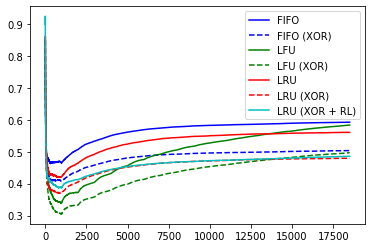

0.5926621621621622
0.5037081081081081
0.5838054054054054
0.49693513513513515
0.5606837837837838
0.47955675675675674
0.48574594594594594


In [6]:
M = 1
N = 18500
test_N = 500
num_of_video = 100
num_of_client = 20
cache_size = 20
zipf_param = 1
s_len = 10
l_len = 100
ch_interval = 1000
rho = 0.5

RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, s_len, l_len, zipf_param)
FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)

t = [n for n in range(N)]

plt.plot(t,FIFO_connection,'b')
plt.plot(t,FIFO_Xconnection,'b--')
plt.plot(t,LFU_connection,'g')
plt.plot(t,LFU_Xconnection,'g--')
plt.plot(t,LRU_connection,'r')
plt.plot(t,LRU_Xconnection,'r--')
plt.plot(t,RL_connection,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

print(FIFO_connection[N-1])
print(FIFO_Xconnection[N-1])
print(LFU_connection[N-1])
print(LFU_Xconnection[N-1])
print(LRU_connection[N-1])
print(LRU_Xconnection[N-1])
print(RL_connection[N-1])

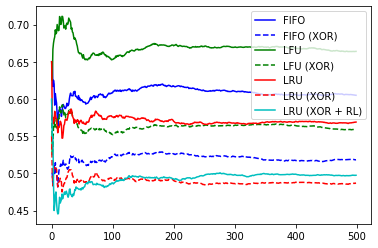

0.6049
0.5182
0.6639
0.5592
0.5689
0.4869
0.4974


In [7]:
t = [n for n in range(test_N)]

plt.plot(t,FIFO_test,'b')
plt.plot(t,FIFO_Xtest,'b--')
plt.plot(t,LFU_test,'g')
plt.plot(t,LFU_Xtest,'g--')
plt.plot(t,LRU_test,'r')
plt.plot(t,LRU_Xtest,'r--')
plt.plot(t,RL_test,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

print(FIFO_test[test_N-1])
print(FIFO_Xtest[test_N-1])
print(LFU_test[test_N-1])
print(LFU_Xtest[test_N-1])
print(LRU_test[test_N-1])
print(LRU_Xtest[test_N-1])
print(RL_test[test_N-1])

# by rho

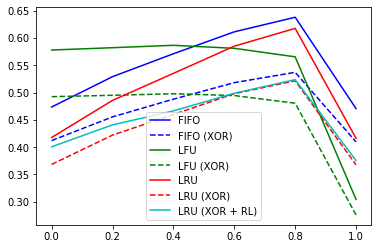

In [8]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

rho_list = [i*0.2 for i in range(6)]

for rho in rho_list:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, s_len, l_len, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(rho_list,FIFO_connection_list,'b')
plt.plot(rho_list,FIFO_Xconnection_list,'b--')
plt.plot(rho_list,LFU_connection_list,'g')
plt.plot(rho_list,LFU_Xconnection_list,'g--')
plt.plot(rho_list,LRU_connection_list,'r')
plt.plot(rho_list,LRU_Xconnection_list,'r--')
plt.plot(rho_list,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

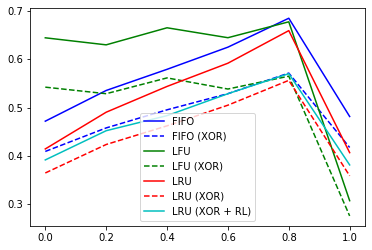

In [9]:
plt.plot(rho_list,FIFO_test_list,'b')
plt.plot(rho_list,FIFO_Xtest_list,'b--')
plt.plot(rho_list,LFU_test_list,'g')
plt.plot(rho_list,LFU_Xtest_list,'g--')
plt.plot(rho_list,LRU_test_list,'r')
plt.plot(rho_list,LRU_Xtest_list,'r--')
plt.plot(rho_list,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Cache Size

In [10]:
rho = 0.5

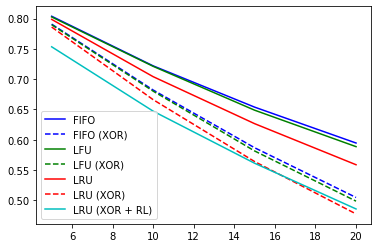

In [11]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

cache_sizes = [i*5 for i in range(1,5)]

for size in cache_sizes:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, size, s_len, l_len, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(cache_sizes,FIFO_connection_list,'b')
plt.plot(cache_sizes,FIFO_Xconnection_list,'b--')
plt.plot(cache_sizes,LFU_connection_list,'g')
plt.plot(cache_sizes,LFU_Xconnection_list,'g--')
plt.plot(cache_sizes,LRU_connection_list,'r')
plt.plot(cache_sizes,LRU_Xconnection_list,'r--')
plt.plot(cache_sizes,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

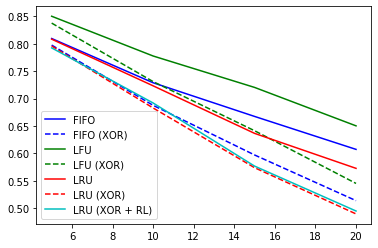

In [12]:
plt.plot(cache_sizes,FIFO_test_list,'b')
plt.plot(cache_sizes,FIFO_Xtest_list,'b--')
plt.plot(cache_sizes,LFU_test_list,'g')
plt.plot(cache_sizes,LFU_Xtest_list,'g--')
plt.plot(cache_sizes,LRU_test_list,'r')
plt.plot(cache_sizes,LRU_Xtest_list,'r--')
plt.plot(cache_sizes,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Number of Clients

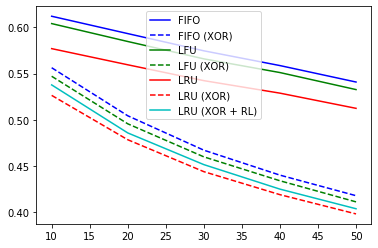

In [13]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_clients = [i*10 for i in range(1,6)]

for num in number_of_clients:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num, cache_size, s_len, l_len, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num, size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num, size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num, size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(number_of_clients,FIFO_connection_list,'b')
plt.plot(number_of_clients,FIFO_Xconnection_list,'b--')
plt.plot(number_of_clients,LFU_connection_list,'g')
plt.plot(number_of_clients,LFU_Xconnection_list,'g--')
plt.plot(number_of_clients,LRU_connection_list,'r')
plt.plot(number_of_clients,LRU_Xconnection_list,'r--')
plt.plot(number_of_clients,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

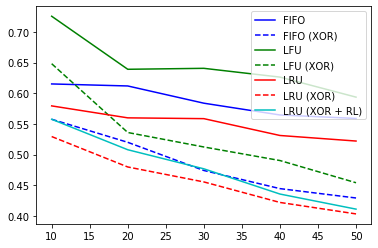

In [14]:
plt.plot(number_of_clients,FIFO_test_list,'b')
plt.plot(number_of_clients,FIFO_Xtest_list,'b--')
plt.plot(number_of_clients,LFU_test_list,'g')
plt.plot(number_of_clients,LFU_Xtest_list,'g--')
plt.plot(number_of_clients,LRU_test_list,'r')
plt.plot(number_of_clients,LRU_Xtest_list,'r--')
plt.plot(number_of_clients,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Number of Videos

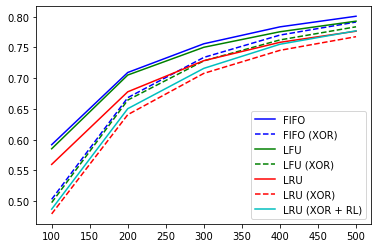

In [15]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_videos = [i*100 for i in range(1,6)]

for num in number_of_videos:
    RL_connection, RL_test = RL_Caching(M, N, num, num_of_client, cache_size, s_len, l_len, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num, num_of_client, size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num, num_of_client, size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num, num_of_client, size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(number_of_videos,FIFO_connection_list,'b')
plt.plot(number_of_videos,FIFO_Xconnection_list,'b--')
plt.plot(number_of_videos,LFU_connection_list,'g')
plt.plot(number_of_videos,LFU_Xconnection_list,'g--')
plt.plot(number_of_videos,LRU_connection_list,'r')
plt.plot(number_of_videos,LRU_Xconnection_list,'r--')
plt.plot(number_of_videos,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

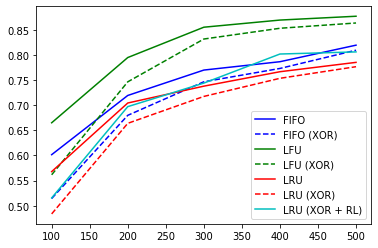

In [16]:
plt.plot(number_of_videos,FIFO_test_list,'b')
plt.plot(number_of_videos,FIFO_Xtest_list,'b--')
plt.plot(number_of_videos,LFU_test_list,'g')
plt.plot(number_of_videos,LFU_Xtest_list,'g--')
plt.plot(number_of_videos,LRU_test_list,'r')
plt.plot(number_of_videos,LRU_Xtest_list,'r--')
plt.plot(number_of_videos,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by zipf parameter

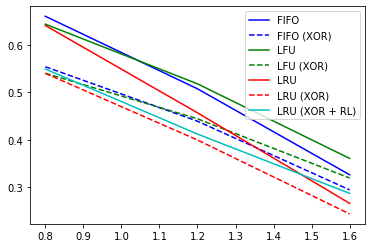

In [17]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

zipf_parameters = [i*0.4 for i in range(2, 5)]

for zipf in zipf_parameters:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, s_len, l_len, zipf)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, size, zipf)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, size, zipf)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, size, zipf)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(zipf_parameters,FIFO_connection_list,'b')
plt.plot(zipf_parameters,FIFO_Xconnection_list,'b--')
plt.plot(zipf_parameters,LFU_connection_list,'g')
plt.plot(zipf_parameters,LFU_Xconnection_list,'g--')
plt.plot(zipf_parameters,LRU_connection_list,'r')
plt.plot(zipf_parameters,LRU_Xconnection_list,'r--')
plt.plot(zipf_parameters,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

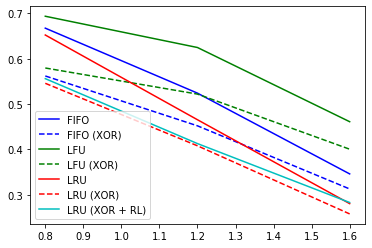

In [18]:
plt.plot(zipf_parameters,FIFO_test_list,'b')
plt.plot(zipf_parameters,FIFO_Xtest_list,'b--')
plt.plot(zipf_parameters,LFU_test_list,'g')
plt.plot(zipf_parameters,LFU_Xtest_list,'g--')
plt.plot(zipf_parameters,LRU_test_list,'r')
plt.plot(zipf_parameters,LRU_Xtest_list,'r--')
plt.plot(zipf_parameters,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()